### HW4 Assignment Disclaimer
*	Author Name: V Harsha Yellela
*	LTU ID: 000798754
*	Work Ownership: This work is my own. It is not copied from classmates (Yes/No): Yes
*	AI Assistance: Percentage of code generated with AI tools
(If greater than 0%, briefly describe how AI was used): 15% (for code formatting and clarification only)
*	Understanding: I understand every part of this code (Yes/No):  Yes
*	Confidence: I am confident that I can modify, adapt, and extend this code on my own (Yes/No): Yes

## XOR with 3 classes

<pre>
   | x0 | x1 |XOR3|
   |----|----|----|
   |0.0 |0.0 | 0  |
   |0.0 |1.0 | 1  |
   |1.0 |0.0 | 1  |
   |1.0 |1.0 | 0  |
   |0.5 |0.5 | 2  |
</pre>

In [30]:
import tensorflow as tf
from tensorflow.python.platform import build_info as tf_build

print("✅ TensorFlow version:", tf.__version__)
print("🧩 Build:", "CUDA" if tf_build.build_info.get("is_cuda_build") else "CPU-only")

# List available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("💻 Detected GPUs:", gpus)

# Optional: print CUDA/cuDNN versions TensorFlow is using
print("🔹 CUDA version:", tf_build.build_info.get("cuda_version", "N/A"))
print("🔹 cuDNN version:", tf_build.build_info.get("cudnn_version", "N/A"))

✅ TensorFlow version: 2.10.1
🧩 Build: CUDA
💻 Detected GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
🔹 CUDA version: 64_112
🔹 cuDNN version: 64_8


In [31]:
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers

# the five different states of the XOR3 gate
X = np.array([[0,0],[0,1],[1,0],[1,1],[0.5,0.5],[0.6,0.6]])

# the five expected results in the same order
y = np.array([[0],[1],[1],[0],[2],[2]])

Xt = np.array([[0,0.1],[0.1,1],[0.9,0],[0.9,1],[0.55,0.45]])
yt = np.array([[0],[1],[1],[0],[2]])

In [32]:
act_func = ('relu', 'elu', 'sigmoid', 'tanh', 'leaky_relu')
optimz = ('SGD', 'RMSprop', 'Adam')
loss_func = 'sparse_categorical_crossentropy'

print("Activation functions:", act_func)
print("Optimizers:", optimz)
print("Loss function:", loss_func)

Activation functions: ('relu', 'elu', 'sigmoid', 'tanh', 'leaky_relu')
Optimizers: ('SGD', 'RMSprop', 'Adam')
Loss function: sparse_categorical_crossentropy


In [33]:
# Using 'sparse_categorical_crossentropy'
def XOR3_eval(param):
    """
    param indices:
      0: num of hidden neurons
      1: learning rate
      2: batch size
      3: activation function index
      4: loss function index (fixed, not really used)
      5: optimizer index
    """
    global model
    model = Sequential([
        keras.Input(shape=(2,)),
        Dense(int(param[0]), activation=act_func[round(param[3])]),
        Dense(3, activation='softmax')
    ])

    if round(param[5]) == 0:
        optmzr = optimizers.SGD(learning_rate=param[1])
    elif round(param[5]) == 1:
        optmzr = optimizers.RMSprop(learning_rate=param[1])
    else:
        optmzr = optimizers.Adam(learning_rate=param[1])

    model.compile(
    optimizer=optmzr,
    loss=loss_func, # target labels are integers
    metrics=['accuracy']
    )
    model.fit(X, y, batch_size=int(param[2]), epochs=int(param[4]), verbose=0)

    loss, acc = model.evaluate(Xt, yt, verbose=0)
    return loss
    # score = loss + (1 - acc) # minimize error and  loss
    # return score
    # return 1-acc

# test_param = [4, 0.5, 2, 2, 0, 1]  # neurons, lr, bsize, act='sigmoid', loss, opt='RMSprop'
# print("loss =", XOR3_eval(test_param))

In the initial version, the objective function used validation loss as the optimization metric.
However, during experimentation (see figure below), the model converged to a degenerate solution where all input samples were classified into a single class (Class 2).
Although this produced a small numerical loss (≈ 0.002), the prediction accuracy was poor, demonstrating that low loss does not necessarily indicate correct class separation.

To prevent this issue, the objective function was modified to minimize the classification error ( 1 − accuracy ) and loss instead of only the loss value.
By optimizing for accuracy, the evolutionary search (ES (1+1) with 1/5 rule) avoids premature convergence to trivial solutions and ensures that acceptable models correctly learn all three XOR3 classes rather than collapsing to a single output.

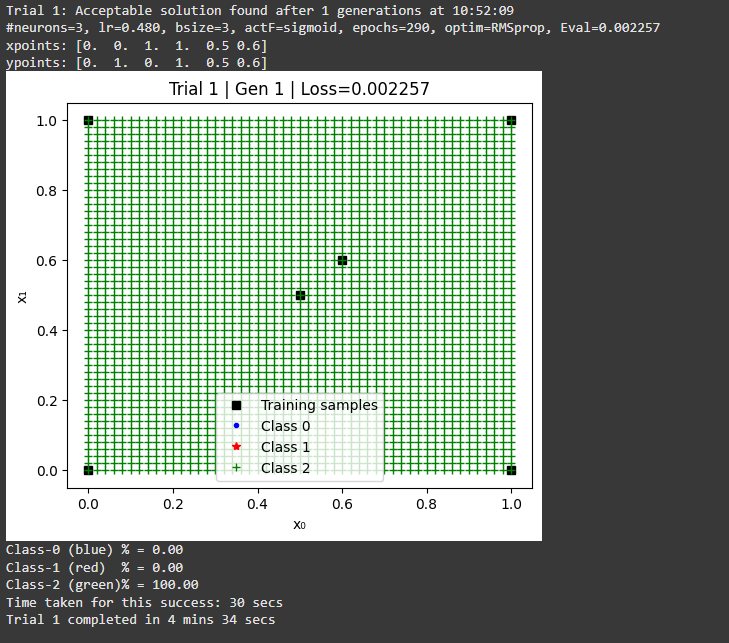


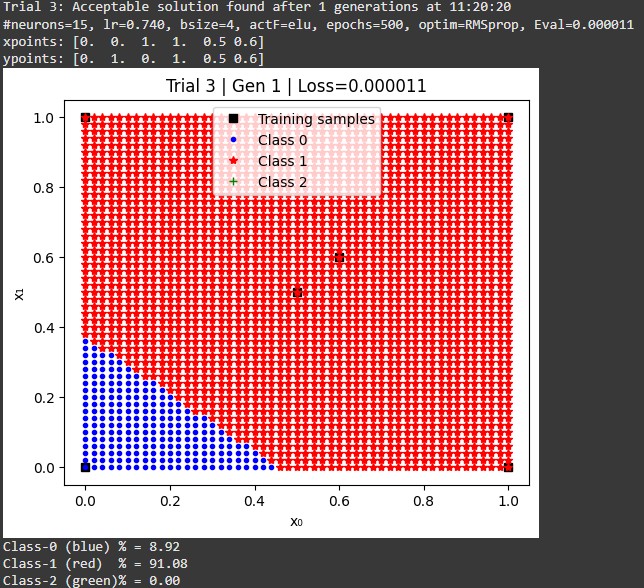

In [34]:
def print_HP_found(x, eval):
    print(
        f"#neurons={int(x[0])}, "
        f"lr={x[1]:.3f}, "
        f"bsize={int(x[2])}, "
        f"actF={act_func[int(round(x[3]))]}, "
        f"epochs={int(x[4])}, "
        f"optim={optimz[int(round(x[5]))]}, "
        f"Eval={eval:.6f}"
    )

In [35]:
def boundary_coverage_ok(model, min_pct=0.05):
    xs = np.arange(0.0, 1.02, 0.02)
    ys = np.arange(0.0, 1.02, 0.02)
    xx, yy = np.meshgrid(xs, ys)
    grid = np.c_[xx.ravel(), yy.ravel()]
    preds = np.argmax(model.predict(grid, verbose=0), axis=1)
    counts = np.bincount(preds, minlength=3)
    total = counts.sum()
    return np.all(counts / total >= min_pct), counts / total

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model

def plot_XOR3_decision_boundary(model=None, model_path=None, title="Decision Boundary for XOR3"):
    # Load from file if a path is given
    if model is None and model_path is not None:
        model = load_model(model_path)

    # Extract training samples for plotting
    xpoint = X[:, 0]
    ypoint = X[:, 1]
    print("xpoints:", xpoint)
    print("ypoints:", ypoint)

    # Prepare storage for predicted class coordinates
    xp_cls0, yp_cls0 = np.array([]), np.array([])
    xp_cls1, yp_cls1 = np.array([]), np.array([])
    xp_cls2, yp_cls2 = np.array([]), np.array([])
    num0 = num1 = num2 = 0

    # Scan 2D grid [0,1]×[0,1]
    for x in np.arange(0.0, 1.02, 0.02):
        for y in np.arange(0.0, 1.02, 0.02):
            xy = np.array([[x, y]], dtype=np.float32)
            pred = np.argmax(model.predict(xy, verbose=0))
            if pred == 0:
                xp_cls0 = np.append(xp_cls0, x)
                yp_cls0 = np.append(yp_cls0, y)
                num0 += 1
            elif pred == 1:
                xp_cls1 = np.append(xp_cls1, x)
                yp_cls1 = np.append(yp_cls1, y)
                num1 += 1
            else:
                xp_cls2 = np.append(xp_cls2, x)
                yp_cls2 = np.append(yp_cls2, y)
                num2 += 1

    # --- Plot the decision regions ---
    plt.figure(figsize=(6, 5))
    plt.plot(xpoint, ypoint, 'ks', label='Training samples')
    plt.plot(xp_cls0, yp_cls0, 'b.', label='Class 0')
    plt.plot(xp_cls1, yp_cls1, 'r*', label='Class 1')
    plt.plot(xp_cls2, yp_cls2, 'g+', label='Class 2')
    plt.title(title)
    plt.xlabel("x₀")
    plt.ylabel("x₁")
    plt.legend()
    plt.show()

    # --- Print class percentages ---
    total = num0 + num1 + num2
    print(f"Class-0 (blue) % = {num0/total*100:.2f}")
    print(f"Class-1 (red)  % = {num1/total*100:.2f}")
    print(f"Class-2 (green)% = {num2/total*100:.2f}")

In [37]:
def format_time(seconds):
    """Return time in 'hh hrs mm mins ss secs' format."""
    seconds = int(seconds)
    hrs, rem = divmod(seconds, 3600)
    mins, secs = divmod(rem, 60)
    parts = []
    if hrs > 0:
        parts.append(f"{hrs} hr{'s' if hrs>1 else ''}")
    if mins > 0:
        parts.append(f"{mins} min{'s' if mins>1 else ''}")
    if secs > 0 or not parts:
        parts.append(f"{secs} sec{'s' if secs!=1 else ''}")
    return " ".join(parts)

[#neurons, lr, bsize, actfun, lossfun, optmzr]

************************** Trial # = 1 started at 11:11:23 **************************
Trial 1: Initializing hyperparameters
Trial 1: Evaluating parent
Trial 1: Parent value: 0.0009463598835282028
Trial 1: Starting evolution loop
Trial 1, Gen 1: Starting generation
Trial 1, Gen 1: Mutating hyperparameters
Trial 1, Gen 1: Offspring: [2.00000000e+00 3.10000000e-01 1.71903884e+00 0.00000000e+00
 5.00000000e+02 1.09631077e+00]
Trial 1, Gen 1: Evaluating offspring
Trial 1, Gen 1: Offspring value: 1.0705034732818604
Trial 1, Gen 1: Offspring rejected
Skipped: boundary coverage too low [0. 1. 0.]
Trial 1, Gen 2: Starting generation
Trial 1, Gen 2: Mutating hyperparameters
Trial 1, Gen 2: Offspring: [  2.           0.49         3.83912853   3.05765771 350.84962229
   0.        ]
Trial 1, Gen 2: Evaluating offspring
Trial 1, Gen 2: Offspring value: 0.7434396743774414
Trial 1, Gen 2: Offspring rejected

Trial 1: Acceptable solution found after 2 gen

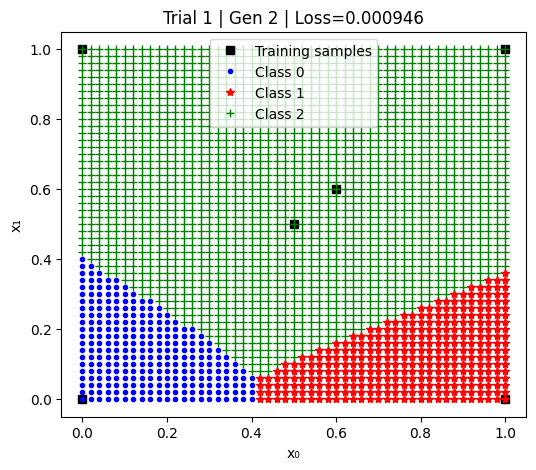

Class-0 (blue) % = 10.34
Class-1 (red)  % = 13.23
Class-2 (green)% = 76.43
Time taken for this success: 11 secs
Trial 1 completed in 1 min 41 secs

************************** Trial # = 2 started at 11:13:04 **************************
Trial 2: Initializing hyperparameters
Trial 2: Evaluating parent
Trial 2: Parent value: 0.9923602938652039
Trial 2: Starting evolution loop
Trial 2, Gen 1: Starting generation
Trial 2, Gen 1: Mutating hyperparameters
Trial 2, Gen 1: Offspring: [  2.           1.5          5.           3.17493756 500.
   2.        ]
Trial 2, Gen 1: Evaluating offspring
Trial 2, Gen 1: Offspring value: 1.8310973644256592
Trial 2, Gen 1: Offspring rejected
Trial 2, Gen 2: Starting generation
Trial 2, Gen 2: Mutating hyperparameters
Trial 2, Gen 2: Offspring: [  2.           1.5          1.           4.         257.43212737
   0.66528259]
Trial 2, Gen 2: Evaluating offspring
Trial 2, Gen 2: Offspring value: 4.789483070373535
Trial 2, Gen 2: Offspring rejected
Trial 2, Gen 3: S

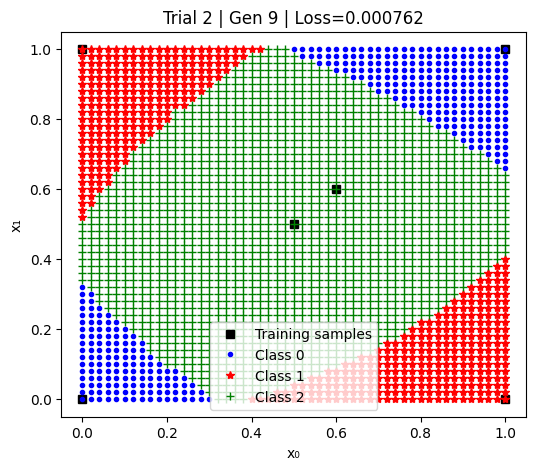

Class-0 (blue) % = 13.96
Class-1 (red)  % = 20.18
Class-2 (green)% = 65.86
Time taken for this success: 28 secs
Trial 2 completed in 1 min 57 secs

************************** Trial # = 3 started at 11:15:02 **************************
Trial 3: Initializing hyperparameters
Trial 3: Evaluating parent
Trial 3: Parent value: 1.0761388540267944
Trial 3: Starting evolution loop
Trial 3, Gen 1: Starting generation
Trial 3, Gen 1: Mutating hyperparameters
Trial 3, Gen 1: Offspring: [1.60000000e+01 1.00000000e-02 1.00000000e+00 4.00000000e+00
 5.00000000e+02 3.26879267e-01]
Trial 3, Gen 1: Evaluating offspring
Trial 3, Gen 1: Offspring value: 0.4823610186576843
Trial 3, Gen 1: Offspring accepted, new parent value: 0.4823610186576843
Trial 3, Gen 2: Starting generation
Trial 3, Gen 2: Mutating hyperparameters
Trial 3, Gen 2: Offspring: [ 16.           0.53         1.           2.40407826 500.
   0.        ]
Trial 3, Gen 2: Evaluating offspring
Trial 3, Gen 2: Offspring value: 0.015803096815943718

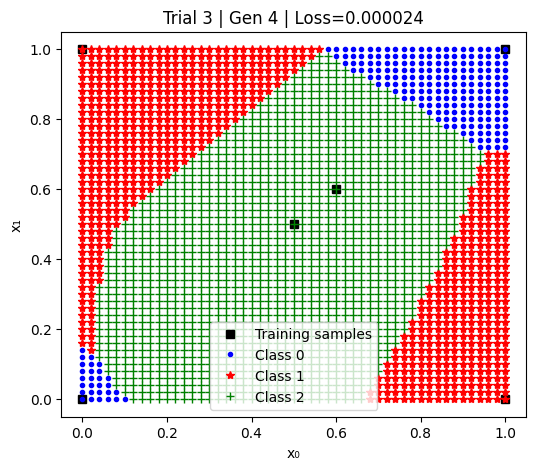

Class-0 (blue) % = 8.57
Class-1 (red)  % = 31.37
Class-2 (green)% = 60.05
Time taken for this success: 16 secs
Trial 3 completed in 1 min 49 secs

 Total runtime for all trials: 5 mins 28 secs

System Success = 100.00%
Average # of generations used = 5

GLOBAL BEST MODEL FOUND
  • Trial #: 3
  • Generation #: 4
  • Best Loss (Eval): 0.00002439
  • Params: [ 16.           0.51         2.88284102   0.54589589 408.41657673
   0.76597614]


In [38]:
import numpy as np
from keras.models import save_model
import time


# constants
MaxGen   = 35    # generations per trial
MaxTrial = 3     # number of independent trials
numVar   = 6     # number of hyperparameters

# initial step size and adjustment ratio
stepSize_i = 0.82     # initial step size
stepSize_r = 0.82     # step size ratio (Rechenberg constant)

totgen  = 0
foundCnt = 0
objfunc = XOR3_eval   # link to objective function

print("[#neurons, lr, bsize, actfun, lossfun, optmzr]")

overall_start = time.time()

global_best_val = float('inf')
global_best_trial = None
global_best_gen = None
global_best_params = None

for trial in range(MaxTrial):
    trial_start = time.time()
    print(f"\n************************** Trial # = {trial+1} started at {time.strftime('%H:%M:%S')} **************************")
    print(f"Trial {trial+1}: Initializing hyperparameters")

    best_p_val = 9999.0
    xp = np.empty(numVar)  # parent
    xo = np.empty(numVar)  # offspring
    successCnt = 0
    WindowSize = 10
    stepSize = stepSize_i

    # --- initialize hyperparameters (start point) ---
    hparams = [
        (np.random.randint(2, 16), 2, 16),          # hidden neurons
        (round(np.random.uniform(0.01, 1.5), 2), 0.01, 1.5),  # learning rate
        (np.random.randint(1, 5), 1, 5),            # batch size
        (np.random.randint(0, len(act_func)), 0, len(act_func)-1),  # activation
        (np.random.randint(100, 501), 100, 500),                                  # loss fixed
        (np.random.randint(0, len(optimz)), 0, len(optimz)-1)       # optimizer
    ]

    for i in range(numVar):
        xp[i] = hparams[i][0]

    # evaluate parent
    print(f"Trial {trial+1}: Evaluating parent")
    p_val = objfunc(xp)
    print(f"Trial {trial+1}: Parent value: {p_val}")

    # --- evolution loop ---
    print(f"Trial {trial+1}: Starting evolution loop")
    for g in range(1, MaxGen + 1):
        print(f"Trial {trial+1}, Gen {g}: Starting generation")

        # 1/5 success rule step-size adaptation
        if (g % WindowSize) == 0:
            print(f"Trial {trial+1}, Gen {g}: Adapting step size")
            if successCnt > (WindowSize * 0.2):
                stepSize /= stepSize_r
            elif successCnt < (WindowSize * 0.2):
                stepSize *= stepSize_r
            successCnt = 0
            print(f"Trial {trial+1}, Gen {g}: New step size: {stepSize}")

        # mutate each hyperparameter with scaled step size
        print(f"Trial {trial+1}, Gen {g}: Mutating hyperparameters")
        for i in range(numVar):
            range_scale = hparams[i][2] - hparams[i][1]
            variation = np.random.normal(0.0, stepSize) * range_scale
            if i == 1:   # learning rate: keep decimals
                xo[i] = round(xp[i] + variation, 2)
            else:
                xo[i] = xp[i] + variation
            xo[i] = np.clip(xo[i], hparams[i][1], hparams[i][2])

        print(f"Trial {trial+1}, Gen {g}: Offspring: {xo}")

        # evaluate offspring
        print(f"Trial {trial+1}, Gen {g}: Evaluating offspring")
        o_val = objfunc(xo)
        print(f"Trial {trial+1}, Gen {g}: Offspring value: {o_val}")

        # selection
        if o_val < p_val:
            xp = xo.copy()
            p_val = o_val
            successCnt += 1
            print(f"Trial {trial+1}, Gen {g}: Offspring accepted, new parent value: {p_val}")
        else:
            print(f"Trial {trial+1}, Gen {g}: Offspring rejected")

        # check acceptable solution
        if p_val < 0.01:

            ok, pct = boundary_coverage_ok(model, min_pct=0.05)
            if not ok:
                print(f"Skipped: boundary coverage too low {pct}")
                continue

            success_time = time.time()
            print(f"\nTrial {trial+1}: Acceptable solution found after {g} generations at {time.strftime('%H:%M:%S')}")
            print_HP_found(xp, p_val)

            plot_XOR3_decision_boundary(model, title=f"Trial {trial+1} | Gen {g} | Loss={p_val:.6f}")

            #Local (trial) best save
            if p_val < best_p_val:
                best_p_val = p_val
                save_model(model, f"bestXOR_trial{trial+1}.keras")

            #Global best comparison
            if p_val < global_best_val:
                global_best_val = p_val
                global_best_trial = trial + 1
                global_best_gen = g
                global_best_params = xp.copy()
                save_model(model, "bestXOR.keras")  # overwrite global best

            totgen += g
            foundCnt += 1
            print(f"Time taken for this success: {format_time(success_time - trial_start)}")
            break  # stop this trial early if success

    trial_end = time.time()
    print(f"Trial {trial+1} completed in {format_time(trial_end - trial_start)}")

    # end of one trial
overall_end = time.time()
print(f"\n Total runtime for all trials: {format_time(overall_end - overall_start)}")
print(f"\nSystem Success = {foundCnt / MaxTrial * 100:.2f}%")
totgen += (MaxTrial - foundCnt) * MaxGen
print(f"Average # of generations used = {totgen / MaxTrial:.0f}")

if global_best_trial is not None:
    print("\nGLOBAL BEST MODEL FOUND")
    print(f"  • Trial #: {global_best_trial}")
    print(f"  • Generation #: {global_best_gen}")
    print(f"  • Best Loss (Eval): {global_best_val:.8f}")
    print(f"  • Params: {global_best_params}")
else:
    print("\n No acceptable solution found across all trials.")

xpoints: [0.  0.  1.  1.  0.5 0.6]
ypoints: [0.  1.  0.  1.  0.5 0.6]


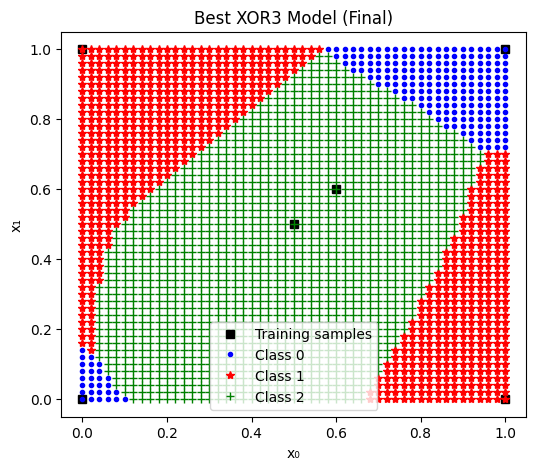

Class-0 (blue) % = 8.57
Class-1 (red)  % = 31.37
Class-2 (green)% = 60.05


In [39]:
plot_XOR3_decision_boundary(model_path="bestXOR.keras", title="Best XOR3 Model (Final)")

In [40]:
print (model.predict(X))
print (model.predict(X, verbose=0).round())
(loss, acc) = model.evaluate(Xt, yt)
print (f"loss = {loss}, acc = {acc}")

1/1 [==============================] - 0s 21ms/step
[[1.0000000e+00 1.4254704e-11 2.8782497e-15]
 [0.0000000e+00 1.0000000e+00 3.0293807e-34]
 [0.0000000e+00 1.0000000e+00 4.1855402e-17]
 [1.0000000e+00 2.6389671e-13 1.8747608e-11]
 [1.9399259e-25 1.5580636e-14 1.0000000e+00]
 [5.6950194e-18 1.5173263e-12 1.0000000e+00]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]
1/1 [==============================] - 0s 15ms/step - loss: 2.4389e-05 - accuracy: 1.0000
loss = 2.4388733436353505e-05, acc = 1.0


In [41]:
# model save into a file and reloading the model
model.summary()
# model.save('xor3.keras') # the file is stored on the cloud account. Will stay a day

model.load_weights('bestXOR.keras')
print (model.predict(X))
print (model.predict(X, verbose=0).round())
model.evaluate(Xt, yt)

m2 = keras.models.load_model('bestXOR.keras')
m2.summary()
print (m2.predict(X))
print (m2.predict(X, verbose=0).round())
(loss, acc) = m2.evaluate(Xt, yt)
print (f"loss = {loss}, acc = {acc}")

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_104 (Dense)           (None, 16)                48        
                                                                 
 dense_105 (Dense)           (None, 3)                 51        
                                                                 
Total params: 99
Trainable params: 99
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 13ms/step
[[1.0000000e+00 1.4254704e-11 2.8782497e-15]
 [0.0000000e+00 1.0000000e+00 3.0293807e-34]
 [0.0000000e+00 1.0000000e+00 4.1855402e-17]
 [1.0000000e+00 2.6389671e-13 1.8747608e-11]
 [1.9399259e-25 1.5580636e-14 1.0000000e+00]
 [5.6950194e-18 1.5173263e-12 1.0000000e+00]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]
1/1 [==============================] - 0s 15ms/step - los

In [42]:
# # Using 'categorical_crossentropy'

# model = Sequential([
#     keras.Input(shape=(2,)),
#     Dense(16, activation='relu'),
#     Dense(3, activation='softmax')
# ])
# model.compile(
#   optimizer='rmsprop',
#   loss='categorical_crossentropy', # target labels are 1hot encoded format
#   metrics=['accuracy']
# )

# # Converting y to one-hot encoded format with shape (5,3)
# y_1hot = keras.utils.to_categorical(y, num_classes=3)
# model.fit(X, y_1hot, batch_size=1, epochs=1300, verbose=0)
# print (model.predict(X))
# print (model.predict(X, verbose=0).round())
# yt_1hot = keras.utils.to_categorical(yt, num_classes=3)
# model.evaluate(Xt, yt_1hot)